## Capstone Project - The Battle of Neighborhoods (Week 5)

### Introduction/Business Problem

Houston, Texas is one of the biggest cities in the U.S. with a high population density and is well known for its energy industry. To capitalize on Houston’s success, a major company would like to determine which neighborhood in Houston in Harris County, Texas to open up a Mexican Restaurant. The CEO, investors, and stakeholders would be interested in this project. They specifically would like it:

1.	near less other competitive Mexican restaurants,

2.	with smooth traffic, and 

3.	near a great deal of markets and residential buildings


### Data

The data that was collected included the number of Mexican restaurants in every Houston neighborhood.

• Foursquare data was used to identify and analyze these locations

•	The longitude and latitude coordinates as well as the population of these neighborhoods was obtained from the U.S. Geological Survey (USGS) website

•	The traffic counts data was obtained from the City of Houston GIS Open Data Portal

These are important in selecting the best location for a Mexican Restaurant according to all those involved in this decision.


### First, let us get all the dependencies we need

In [302]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

! install geopy
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install -U scikit-learn scipy matplotlib

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API la
import folium # map rendering library

print('Libraries imported.')

install: missing destination file operand after 'geopy'
Try 'install --help' for more information.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Requirement already up-to-date: scikit-learn in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (0.21.3)
Requirement already up-to-date: scipy in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (1.3.3)
Requirement already up-to-date: matplotlib in /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages (3.1.2)
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


### Let us load the data and then do some data wrangling

In [303]:
from pprint import pprint

data = json.load(open('us_cities_data.json'))

#### Since this file contains data for all U.S cities, let us get only the data for Harris County in Texas State 

In [304]:
new_features = []
for element in data["features"]:
    if 'TX' in element["properties"]["state"] and element["properties"]["county"] == 'Harris':
        new_features.append(element)              

data["features"] = new_features

#### All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [305]:
neighborhoods_data = data['features']

#### Let us see our first item in the list

In [306]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'bx729wr3020.18249',
 'geometry': {'type': 'Point', 'coordinates': [-95.1718772, 29.7782823]},
 'geometry_name': 'geom',
 'properties': {'gnis_id': 1373144,
  'ansicode': '2407640',
  'feature': 'Census',
  'feature2': '-999',
  'name': 'Cloverleaf',
  'pop_2010': 22942,
  'county': 'Harris',
  'countyfips': '201',
  'state': 'TX',
  'state_fips': '48',
  'latitude': 29.7782823,
  'longitude': -95.1718772,
  'poppllat': 29.7782823,
  'poppllong': -95.1718772,
  'elev_in_m': 8,
  'elev_in_ft': 26,
  'bbox': [-95.1718772, 29.7782823, -95.1718772, 29.7782823]}}

#### Let us load the data into a pandas dataframe

In [307]:
# define the dataframe columns
column_names = ['Neighborhood', 'County', 'State', 'Latitude', 'Longitude', 'Population'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#### Let us loop through the data and fill the dataframe one row at a time.

In [308]:
for data in neighborhoods_data: 
    neighborhood = data['properties']['name']
    county = data['properties']['county']
    state = data['properties']['state']    
    population = data['properties']['pop_2010'] 
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood,
                                          'County': county,
                                          'State': state,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon,
                                         'Population': population}, ignore_index=True)

#### Let us check the first 5 rows of our dataframe

In [309]:
houston_nd = neighborhoods

In [310]:
houston_nd = houston_nd.sort_values(by=['Neighborhood']).reset_index(drop = True)
houston_nd.head()

,Neighborhood,County,State,Latitude,Longitude,Population
0,Addicks,Harris,TX,29.782451,-95.642446,-999
1,Aldine,Harris,TX,29.932445,-95.380215,15869
2,Atascocita,Harris,TX,29.998831,-95.176598,65844
3,Bammel,Harris,TX,30.006888,-95.463550,-999
4,Barrett,Harris,TX,29.879945,-95.062985,3199


#### Let us check the number of neighborhoods

In [311]:
print('The dataframe has {} neighborhoods.'.format(        
        houston_nd.shape[0]
    )
)

The dataframe has 56 neighborhoods.


#### Let us drop the County, State, and Population columns

In [312]:
dfN = houston_nd
dfN.drop("County", axis = 1, inplace=True)
dfN.drop("State", axis = 1, inplace=True)
dfN.drop("Population", axis = 1, inplace=True)
dfN.head()

,Neighborhood,Latitude,Longitude
0,Addicks,29.782451,-95.642446
1,Aldine,29.932445,-95.380215
2,Atascocita,29.998831,-95.176598
3,Bammel,30.006888,-95.463550
4,Barrett,29.879945,-95.062985


#### Let us check that we have the right data types for our map

In [313]:
dfN.dtypes

Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

#### Let us make Neighborhood the last column

In [314]:
df_column = dfN['Neighborhood'] 
dfN.drop('Neighborhood', axis = 1, inplace=True)
dfN.insert(2, 'Neighborhood', df_column)
dfN.head()

,Latitude,Longitude,Neighborhood
0,29.782451,-95.642446,Addicks
1,29.932445,-95.380215,Aldine
2,29.998831,-95.176598,Atascocita
3,30.006888,-95.463550,Bammel
4,29.879945,-95.062985,Barrett


### Let us get a map of Houston and its neighborhoods

#### Downtown Houston is located in the geographic center of the city. Let us get the geographical coordinates

In [315]:
address = 'Houston, Texas'

latitude = 29.763284 #location.latitude
longitude = -95.363271 #location.longitude
print('The geograpical coordinate of Houston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Houston are 29.763284, -95.363271.


#### Let us get the polygon boundaries of Harric County first then add to the map

In [316]:
data = json.load(open('HC.json'))
world_geo = data

In [317]:
# create map of Houston using latitude and longitude values
map_houston= folium.Map(location=[latitude, longitude], zoom_start=10)

#add boundary of Harris County to map
folium.GeoJson(world_geo).add_to(map_houston)

# add markers to map
for lat, lng, neighborhood in zip(dfN['Latitude'], dfN['Longitude'],dfN['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)  
    
map_houston

### Define Foursquare Credentials and Version and explore the venues

In [318]:
CLIENT_ID = 'MVVUFXPWYXSOEZ2PXDT1FLG3LFMVGU3II5HH3FEGJ4CCHEWQ' # your Foursquare ID
CLIENT_SECRET = 'X2QZMZCSAUWX2WD5SMUCJJRS5HTJO5RIK4LJDXM3LTKDDC3F' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: MVVUFXPWYXSOEZ2PXDT1FLG3LFMVGU3II5HH3FEGJ4CCHEWQ
CLIENT_SECRET:X2QZMZCSAUWX2WD5SMUCJJRS5HTJO5RIK4LJDXM3LTKDDC3F


#### Let's explore the first neighborhood in our dataframe.

In [319]:
dfN.loc[0, 'Neighborhood']

'Addicks'

In [320]:
neighborhood_latitude = dfN.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfN.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dfN.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Addicks are 29.7824508, -95.6424457.


#### Let's get the top 100 venues that are in Addicks within a radius of 500 meters

In [321]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=MVVUFXPWYXSOEZ2PXDT1FLG3LFMVGU3II5HH3FEGJ4CCHEWQ&client_secret=X2QZMZCSAUWX2WD5SMUCJJRS5HTJO5RIK4LJDXM3LTKDDC3F&v=20180605&ll=29.7824508,-95.6424457&radius=500&limit=100'

#### Send the GET request and examine the results

In [322]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5de49336b9a389001ba68810'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Energy Corridor',
  'headerFullLocation': 'Energy Corridor, Houston',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 15,
  'suggestedBounds': {'ne': {'lat': 29.786950804500005,
    'lng': -95.63727055167507},
   'sw': {'lat': 29.777950795499994, 'lng': -95.64762084832492}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b3a57c2f964a520226525e3',
       'name': 'Lupe Tortilla Mexican Restaurant',
       'location': {'address': '14555 Grisby Rd',
        'crossStreet': 'near I-10',
        'lat': 29.78290328398995

#### Let's borrow the get_category_type function from the Foursquare lab

In [323]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Let's clean the json and structure it into a pandas dataframe

In [324]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Lupe Tortilla Mexican Restaurant,Mexican Restaurant,29.782903,-95.643100
1,Salata,Salad Place,29.783598,-95.642297
2,North China Restaurant,Chinese Restaurant,29.783944,-95.642419
3,Watson's House of Ale's,Pub,29.782844,-95.643579
4,Wells Fargo,Bank,29.783882,-95.643303
5,Lomonte's Italian Restaurant & Bar,Italian Restaurant,29.782731,-95.642430
6,Ginger Thai,Thai Restaurant,29.783190,-95.643538
7,Drury Inn & Suites Houston West Energy Corridor,Hotel,29.786310,-95.644194
8,Las Ventanas Restaurant & Cantina,Mexican Restaurant,29.782307,-95.642391
9,SUBWAY,Sandwich Place,29.784124,-95.642126


#### Let's get the number of venues that were returned by Foursquare

In [325]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

15 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Houston

In [326]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let's run the above function on each neighborhood and create a new dataframe called houston_venues

In [327]:
houston_venues = getNearbyVenues(names=dfN['Neighborhood'],
                                   latitudes=dfN['Latitude'],
                                   longitudes=dfN['Longitude']
                                  )

Addicks
Aldine
Atascocita
Bammel
Barrett
Bayside Terrace
Baytown
Beaumont Place
Bellaire
Bunker Hill Village
Channelview
Clear Lake City
Cloverleaf
Coady
Crosby
Deer Park
El Lago
Galena Park
Hedwig Village
Highlands
Hilshire Village
Hockley
Houmont Park
Houston
Huffman
Humble
Hunters Creek Village
Jacinto City
Jersey Village
Kingwood
Kinwood
Kohrville
La Porte
Lynchburg
Magnolia Gardens
McNair
Moonshine Hill
Morgan's Point
Mount Houston
Nassau Bay
North Houston
Pasadena
Piney Point Village
Satsuma
Seabrook
Sheldon
Shoreacres
South Houston
Southside Place
Spring
Spring Valley Village
Taylor Lake Village
Tomball
Webster
West University Place
Westfield


 #### Let us check the size  of the resulting dataframe

In [328]:
print(houston_venues.shape)

(477, 7)


#### Let's check how many venues were returned for each neighborhood

In [329]:
houston_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addicks,29.782451,-95.642446,Lupe Tortilla Mexican Restaurant,29.782903,-95.643100,Mexican Restaurant
1,Addicks,29.782451,-95.642446,Salata,29.783598,-95.642297,Salad Place
2,Addicks,29.782451,-95.642446,North China Restaurant,29.783944,-95.642419,Chinese Restaurant
3,Addicks,29.782451,-95.642446,Watson's House of Ale's,29.782844,-95.643579,Pub
4,Addicks,29.782451,-95.642446,Wells Fargo,29.783882,-95.643303,Bank


#### Let us see how many neighborhoods have venues

In [330]:
houston_venues_count  = houston_venues[['Neighborhood', 'Venue Category']]
houston_venues_count = houston_venues_count.groupby('Neighborhood').count()
houston_venues_count.count()

Venue Category    53
dtype: int64

In [331]:
houston_venues_count

,Venue Category
Neighborhood,
Addicks,15
Aldine,1
Atascocita,36
Bammel,21
Barrett,1
Bayside Terrace,2
Baytown,9
Beaumont Place,2
Bellaire,1


#### Let us merge the neighborhoods data and the venues data and plot this on a bar chart

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


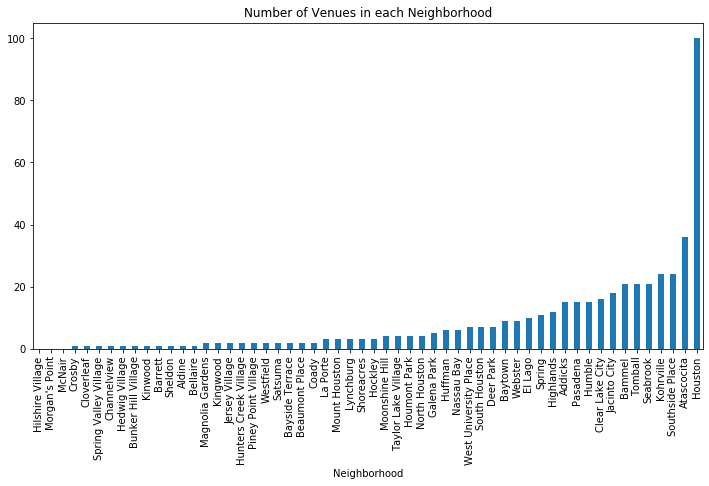

In [332]:
merged_left_venue = pd.merge(left=houston_nd,right=houston_venues_count, how='left', left_on='Neighborhood', right_on='Neighborhood')
h_venues = merged_left_venue[['Neighborhood', 'Venue Category']]
h_venues["Venue Category"].replace(np.nan, 0, inplace=True)
h_venues.set_index('Neighborhood', inplace=True)
h_venues.sort_values('Venue Category',inplace=True)
h_venues.plot(kind="bar", title = "Number of Venues in each Neighborhood", legend = False, figsize=(12, 6))

#### Out of the venues data, let us see which neighborhoods have restaurants and map these restaurants

In [333]:
restaurants = houston_venues[houston_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
restaurants_count  = restaurants[['Neighborhood', 'Venue Category']]
restaurants_count = restaurants_count.groupby('Neighborhood').count()
restaurants_count

,Venue Category
Neighborhood,
Addicks,5
Aldine,1
Atascocita,6
Bammel,5
Baytown,3
Beaumont Place,1
Bunker Hill Village,1
Clear Lake City,3
Deer Park,2


In [334]:
restaurants_count.count()

Venue Category    29
dtype: int64

In [335]:
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.GeoJson(world_geo).add_to(map_restaurants)

# add markers to map
for lat, lng, neighborhood in zip(restaurants['Venue Latitude'], restaurants['Venue Longitude'],restaurants['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  
    
map_restaurants

#### Let us merge the neighborhoods data and the restaurants data and plot this on a bar chart

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


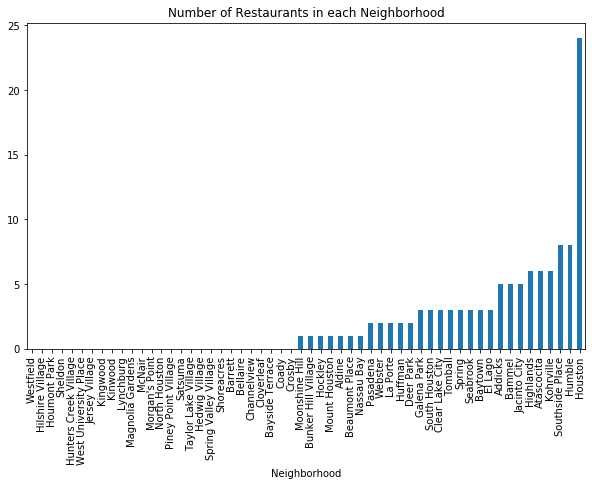

In [336]:
merged_left_restaurant = pd.merge(left=houston_nd,right=restaurants_count, how='left', left_on='Neighborhood', right_on='Neighborhood')
h_restaurants = merged_left_restaurant[['Neighborhood', 'Venue Category']]
h_restaurants["Venue Category"].replace(np.nan, 0, inplace=True)
h_restaurants.set_index('Neighborhood', inplace=True)
h_restaurants.sort_values('Venue Category',inplace=True)
h_restaurants.plot(kind="bar", title = "Number of Restaurants in each Neighborhood", legend = False, figsize=(10, 6))

#### Let us see which neighboords have Mexican restaurants

In [337]:
mex_restaurants = houston_venues[houston_venues['Venue Category'].str.contains('Mexican Restaurant')].reset_index(drop=True)
mex_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addicks,29.782451,-95.642446,Lupe Tortilla Mexican Restaurant,29.782903,-95.643100,Mexican Restaurant
1,Addicks,29.782451,-95.642446,Las Ventanas Restaurant & Cantina,29.782307,-95.642391,Mexican Restaurant
2,Bammel,30.006888,-95.463550,Casa Nueva,30.007800,-95.462041,Mexican Restaurant
3,Baytown,29.735505,-94.977427,Rositas Taqueria,29.737570,-94.978345,Mexican Restaurant
4,Beaumont Place,29.837169,-95.199655,El Mexicano,29.837383,-95.199168,Mexican Restaurant


In [338]:
mex_restaurants_count = mex_restaurants[['Neighborhood', 'Venue Category']]
mex_restaurants_count = mex_restaurants_count.groupby('Neighborhood').count()
mex_restaurants_count

,Venue Category
Neighborhood,
Addicks,2
Bammel,1
Baytown,1
Beaumont Place,1
Galena Park,2
Highlands,1
Houston,4
Huffman,1
Humble,2


#### Let us merge the neighborhoods data and the Mexican restaurants data and plot this on a bar chart

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


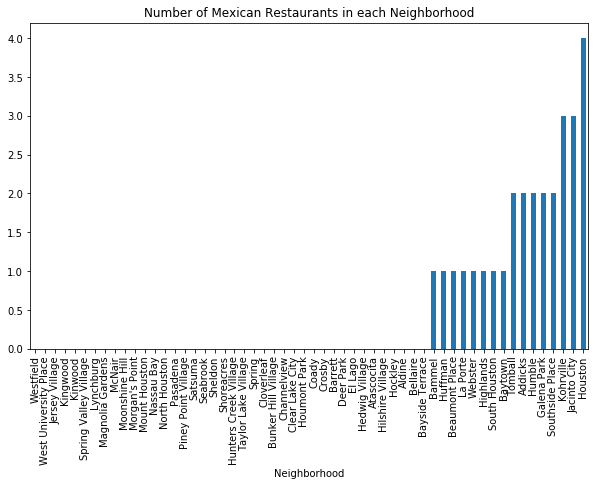

In [339]:
merged_left_mex = pd.merge(left=houston_nd,right=mex_restaurants_count, how='left', left_on='Neighborhood', right_on='Neighborhood')
h_mexican_restaurants = merged_left_mex[['Neighborhood', 'Venue Category']]
h_mexican_restaurants["Venue Category"].replace(np.nan, 0, inplace=True)
h_mexican_restaurants.set_index('Neighborhood', inplace=True)
h_mexican_restaurants.sort_values('Venue Category',inplace=True)
h_mexican_restaurants.plot(kind="bar", title = "Number of Mexican Restaurants in each Neighborhood", legend = False, figsize=(10, 6))

#### Let us map the Mexican restaurants

In [340]:
map_houston_mex = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.GeoJson(world_geo).add_to(map_houston_mex)

# add markers to map
for lat, lng, neighborhood in zip(mex_restaurants['Venue Latitude'], mex_restaurants['Venue Longitude'],mex_restaurants['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston_mex)  
    
map_houston_mex

In [341]:
mex_restaurants_count.count()

Venue Category    16
dtype: int64

#### Let us analyze the neighborhoods with one hot encoding

In [342]:
# one hot encoding
houston_onehot = pd.get_dummies(houston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
houston_onehot['Neighborhood'] = houston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [houston_onehot.columns[-1]] + list(houston_onehot.columns[:-1])
houston_onehot = houston_onehot[fixed_columns]

houston_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Donut Shop,Event Space,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Travel,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kids Store,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Mosque,Movie Theater,Moving Target,Music Venue,New American Restaurant,Nightclub,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pool,Print Shop,Pub,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Addicks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Addicks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Addicks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addicks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Addicks,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Let's examine the new dataframe size

In [343]:
houston_onehot.shape

(477, 145)

#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [344]:
houston_grouped = houston_onehot.groupby('Neighborhood').mean().reset_index()
houston_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Donut Shop,Event Space,Farmers Market,Fast Food Restaurant,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Travel,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Kids Store,Lake,Latin American Restaurant,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Mosque,Movie Theater,Moving Target,Music Venue,New American Restaurant,Nightclub,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pool,Print Shop,Pub,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Skate Park,Smoothie Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Addicks,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.133333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.066667,0.000000,0.066667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,Aldine,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,Atascocita,0.027778,0.000000,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,0.027778,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.027778,0.0,0.027778,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.027778,0.027778,0.0,0.0,0.0,

#### Let's print each neighborhood along with the top 10 most common venues and put in a dataframe

In [345]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [346]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = houston_grouped['Neighborhood']

for ind in np.arange(houston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(houston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addicks,Hotel,Mexican Restaurant,Intersection,Coffee Shop,Sandwich Place,Salad Place,Bank,Italian Restaurant,Thai Restaurant,Cosmetics Shop
1,Aldine,Restaurant,Wings Joint,Dessert Shop,Event Space,Donut Shop,Dive Bar,Discount Store,Disc Golf,Diner,Deli / Bodega
2,Atascocita,Pizza Place,Fast Food Restaurant,Coffee Shop,Sandwich Place,Salon / Barbershop,Big Box Store,BBQ Joint,Chinese Restaurant,Clothing Store,Diner
3,Bammel,Bar,Mexican Restaurant,Seafood Restaurant,Sandwich Place,Chinese Restaurant,Pizza Place,Nightclub,Convenience Store,Wings Joint,Shoe Store
4,Barrett,Bar,Wings Joint,Food,Farmers Market,Event Space,Donut Shop,Dive Bar,Discount Store,Disc Golf,Diner


### Let us use K means clustering to group the neighborhoods according to their 1st most common venue

#### Let us get the best K using the elbow method

In [347]:
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  

x1 = houston_merged['Latitude'].values
x2 = houston_merged['Longitude'].values
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 

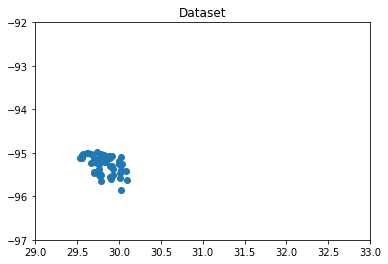

In [348]:
#Visualizing the data 
plt.plot() 
plt.xlim([29, 33]) 
plt.ylim([-97, -92]) 
plt.title('Dataset') 
plt.scatter(x1, x2) 
plt.show() 

In [349]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [350]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.2381167725369458
2 : 0.1573141708734993
3 : 0.12565682674804474
4 : 0.10539950697246553
5 : 0.08770637712458404
6 : 0.07753160000934677
7 : 0.0706432247382323
8 : 0.06535566808140084
9 : 0.061590874261578187


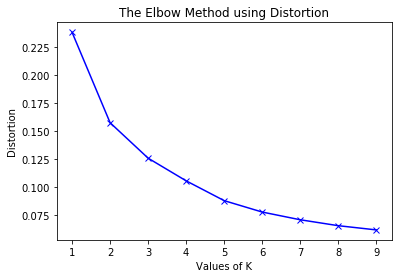

In [351]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [352]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 3.548772465370271
2 : 1.5304256896123278
3 : 1.0201784568786298
4 : 0.7288317942895564
5 : 0.5288537761750967
6 : 0.42038900011405317
7 : 0.34567700727677253
8 : 0.2861582404998875
9 : 0.24715864634181645


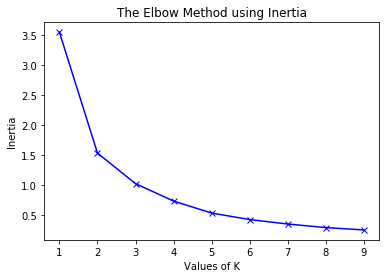

In [353]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### Let us cluster the neighborhoods into 3 clusters based on the elbow method

In [354]:
# set number of clusters
kclusters = 3

houston_grouped_clustering = houston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(houston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 0, 1, 1, 2, 1, 2], dtype=int32)

#### Let us merge the data sets and remove any cities that do not have venues

In [355]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

houston_merged = dfN

houston_merged = houston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right').reset_index(drop=True)
houston_merged.head()

,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,29.782451,-95.642446,Addicks,1,Hotel,Mexican Restaurant,Intersection,Coffee Shop,Sandwich Place,Salad Place,Bank,Italian Restaurant,Thai Restaurant,Cosmetics Shop
1,29.932445,-95.380215,Aldine,1,Restaurant,Wings Joint,Dessert Shop,Event Space,Donut Shop,Dive Bar,Discount Store,Disc Golf,Diner,Deli / Bodega
2,29.998831,-95.176598,Atascocita,1,Pizza Place,Fast Food Restaurant,Coffee Shop,Sandwich Place,Salon / Barbershop,Big Box Store,BBQ Joint,Chinese Restaurant,Clothing Store,Diner
3,30.006888,-95.463550,Bammel,1,Bar,Mexican Restaurant,Seafood Restaurant,Sandwich Place,Chinese Restaurant,Pizza Place,Nightclub,Convenience Store,Wings Joint,Shoe Store
4,29.879945,-95.062985,Barrett,0,Bar,Wings Joint,Food,Farmers Market,Event Space,Donut Shop,Dive Bar,Discount Store,Disc Golf,Diner


#### Let us map these clusters

In [356]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.GeoJson(world_geo).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(houston_merged['Latitude'], houston_merged['Longitude'], houston_merged['Neighborhood'], houston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Let us put the clusters and the 1st Most Common Venue in a dataframe

In [357]:
df_common = houston_merged[['Cluster Labels', '1st Most Common Venue']]
df_common.head()

,Cluster Labels,1st Most Common Venue
0,1,Hotel
1,1,Restaurant
2,1,Pizza Place
3,1,Bar
4,0,Bar


In [358]:
houston_common = df_common.groupby(['Cluster Labels','1st Most Common Venue']).agg({'1st Most Common Venue': ['count']}).reset_index()
houston_common.head()

Cluster Labels 1st Most Common Venue      
                                       count
0              0                   Bar     3
1              0   Rental Car Location     1
2              1   American Restaurant     1
3              1          Antique Shop     1
4              1           Auto Garage     1

In [359]:
houston_common.columns = houston_common.columns.get_level_values(0)
houston_common.head()

,Cluster Labels,1st Most Common Venue,1st Most Common Venue
0,0,Bar,3
1,0,Rental Car Location,1
2,1,American Restaurant,1
3,1,Antique Shop,1
4,1,Auto Garage,1


In [360]:
houston_common.columns.values[2] = "Count"
houston_common.columns

Index(['Cluster Labels', '1st Most Common Venue', 'Count'], dtype='object')

#### Let us switch rows and columns for our bar chart

In [361]:
houston_common_pivot = houston_common.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Count')
houston_common_pivot.replace(np.nan, 0, inplace = True)
houston_common_pivot

1st Most Common Venue,American Restaurant,Antique Shop,Auto Garage,BBQ Joint,Bagel Shop,Bar,Beach,Boat or Ferry,Business Service,Chinese Restaurant,Church,Coffee Shop,Convenience Store,Dive Bar,Fast Food Restaurant,Food,Food & Drink Shop,Gas Station,Health & Beauty Service,Home Service,Hookah Bar,Hotel,Jewelry Store,Lake,Market,Mexican Restaurant,Moving Target,Pharmacy,Pizza Place,Pool,Rental Car Location,Restaurant,Southern / Soul Food Restaurant,Spa,Theme Park,Wings Joint
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### According to the bar chart, we can group each cluster according to its venues/markets so:

#### Cluster 0 - Bar and rental venues
#### Cluster 1 - Multiple venues
#### Cluster 2 - Service and food venues

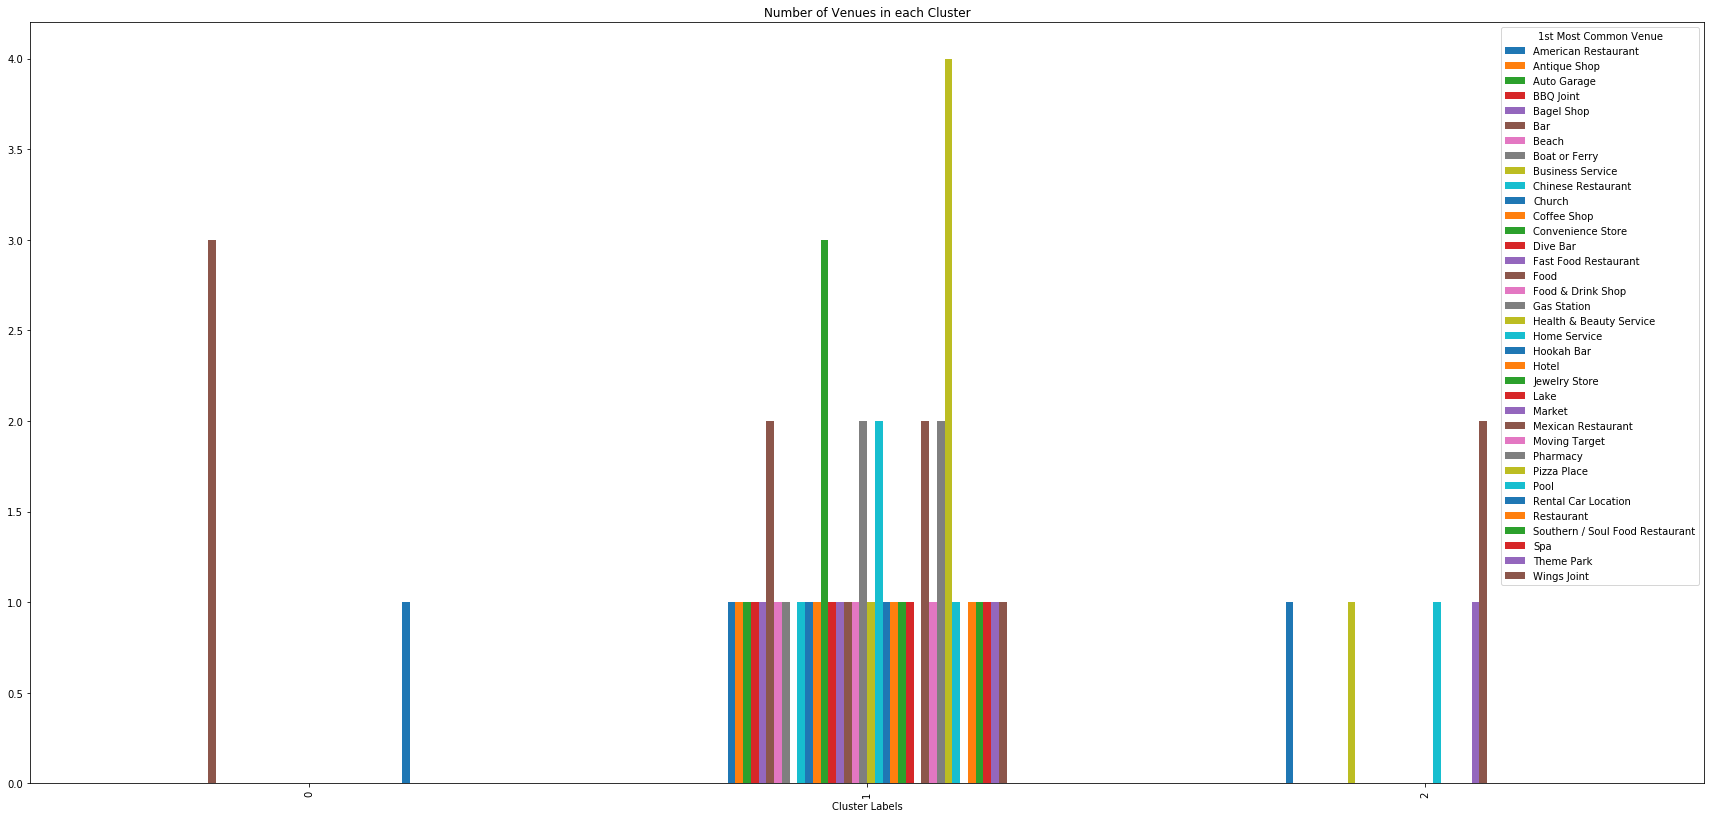

In [362]:
houston_common_pivot.plot(kind='bar',title = 'Number of Venues in each Cluster', figsize=(30, 14))
plt.show()

#### Recall the neighborhoods in each cluster

In [363]:
houston_clusters = houston_merged[['Cluster Labels', 'Neighborhood']].sort_values(by=['Cluster Labels', 'Neighborhood']).reset_index(drop = True)
houston_clusters

,Cluster Labels,Neighborhood
0,0,Barrett
1,0,Kinwood
2,0,Satsuma
3,0,Westfield
4,1,Addicks
5,1,Aldine
6,1,Atascocita
7,1,Bammel
8,1,Bayside Terrace
9,1,Baytown


### Population

Houston has the highest population of over 2 million in Harris County and those neighborhoods with populations of -999 means there is no population information available so we will exclude this data when creating a bar chart

In [364]:
h_population = neighborhoods[['Neighborhood', 'Population']]
h_population = h_population[(h_population.Neighborhood != 'Houston') & (h_population.Population != -999)]. reset_index(drop = True)
h_population.head()

,Neighborhood,Population
0,Cloverleaf,22942
1,Crosby,2299
2,Aldine,15869
3,Atascocita,65844
4,Barrett,3199


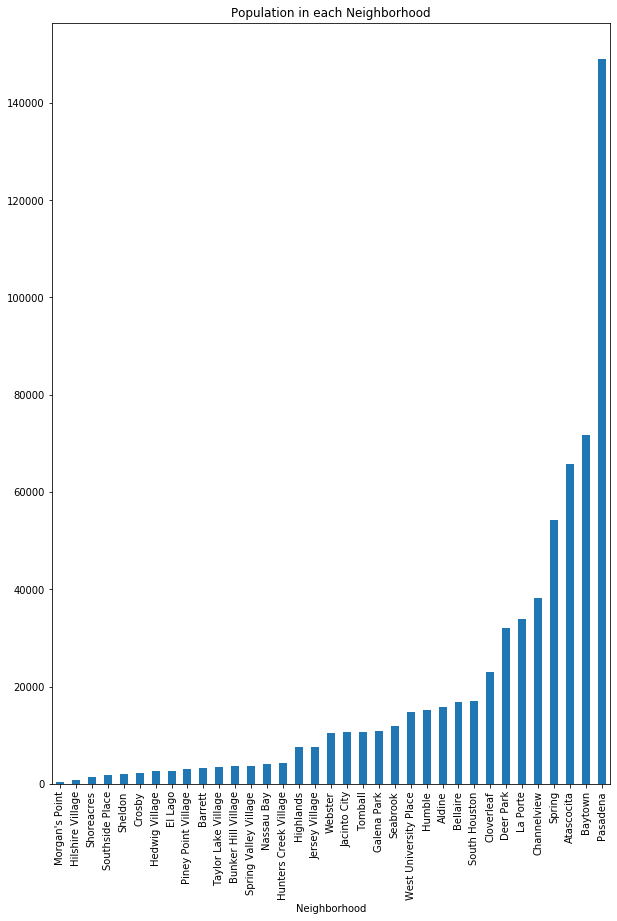

In [365]:
h_population.set_index('Neighborhood', inplace=True)
h_population.sort_values('Population',inplace=True)
h_population.plot(kind="bar", title = "Population in each Neighborhood", legend = False, figsize=(10, 14))

### Traffic analysis

#### Let us get the traffic data. We are specifically looking at ADT (average daily traffic) counts

In [366]:
df_traffic = pd.read_csv('TrafficCounts_OpenData_wm.csv')
print('Data downloaded!')

Data downloaded!


#### Let us make sure the data has the right data types

In [367]:
df_traffic.dtypes

OBJECTID               int64
SEGMENT               object
ADT                  float64
ID                     int64
STREETNAME            object
STREETADDRESS         object
FILENAME              object
PERCENTILESPEED85     object
OUTCOME               object
COLLECTIONTYPE        object
X                    float64
Y                    float64
YEAR                   int64
PRE_NTMP_ADT         float64
POST_NTMP_ADT        float64
PRE_NTMP_SPEED       float64
POST_NTMP_SPEED      float64
POINT_X              float64
POINT_Y              float64
dtype: object

#### Let us install the dependencies for our map

In [368]:
!pip install geopandas
import geopandas as gpd

#### Let us add our shape file

In [369]:
fp = "output.shp"
map_df = gpd.read_file(fp)

# check the GeoDataframe
map_df.head()

,OBJECTID,SEGMENT,ADT,ID,STREETNAME,STREETADDR,FILENAME,PERCENTILE,OUTCOME,COLLECTION,X,Y,YEAR,PRE_NTMP_A,POST_NTMP_,PRE_NTMP_S,POST_NTM_1,POINT_X,POINT_Y,geometry
0,1,SPRR TO WEST LOOP,19402.0,129,BEECHNUT,4610,0129,None,SUCCESS,MAJOR THOROUGHFARE ADT,3093465.52,13815159.57,0,None,None,None,None,-95.456266,29.689146,POINT (-95.45627 29.68915)
1,2,SYNOTT TO W CITY LIMIT,34826.0,158,BELLAIRE,13100,0158,None,SUCCESS,MAJOR THOROUGHFARE ADT,3042291.43,13818867.17,0,None,None,None,None,-95.617039,29.703505,POINT (-95.61704 29.70350)
2,3,CHIMNEY ROCK TO HILLCROFT,25154.0,176,BELLFORT,5614,0176,None,SUCCESS,MAJOR THOROUGHFARE ADT,3084670.97,13803301.70,0,None,None,None,None,-95.485075,29.657281,POINT (-95.48507 29.65728)
3,4,FONDREN TO S GESSNER,21667.0,178,BELLFORT,8000,0178,None,SUCCESS,MAJOR THOROUGHFARE ADT,3074100.26,13802378.25,0,None,None,None,None,-95.518430,29.655612,POINT (-95.51843 29.65561)
4,5,WEST BELT TO SW FWY,18069.0,180,BELLFORT,10200,0180,None,SUCCESS,MAJOR THOROUGHFARE ADT,3061213.60,13800911.51,0,None,None,None,None,-95.559123,29.652629,POINT (-95.55912 29.65263)


#### Let us merge the two data sets for our map

In [370]:
# join the geodataframe with the csv dataframe
merged = map_df.merge(df_traffic, how='left', left_on="OBJECTID", right_on="OBJECTID", suffixes=['', '_'])
merged = merged[['OBJECTID','STREETNAME', 'STREETADDRESS', 'geometry', 'ADT']]
merged.head()

,OBJECTID,STREETNAME,STREETADDRESS,geometry,ADT
0,1,BEECHNUT,4610,POINT (-95.45627 29.68915),19402.0
1,2,BELLAIRE,13100,POINT (-95.61704 29.70350),34826.0
2,3,BELLFORT,5614,POINT (-95.48507 29.65728),25154.0
3,4,BELLFORT,8000,POINT (-95.51843 29.65561),21667.0
4,5,BELLFORT,10200,POINT (-95.55912 29.65263),18069.0


#### Now let's visualize the traffic counts

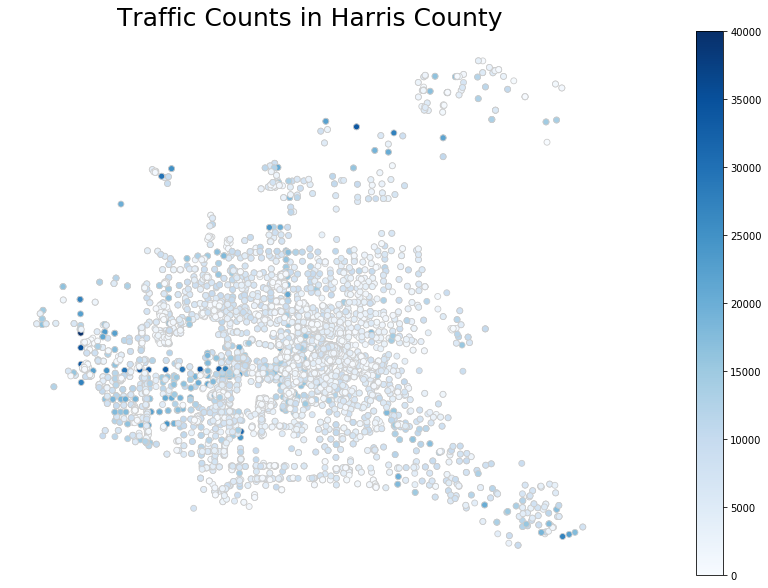

In [371]:
# set the value column that will be visualised
variable = 'ADT'
# set the range for the choropleth values
vmin, vmax = 0, 40000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Traffic Counts in Harris County', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([])
# add the colorbar to the figure
fig.colorbar(sm)
# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

### Results and Discussion

Our analysis looked at the neighborhoods in Harris County, Texas and their venues in relation to restaurants and Mexican restaurants as well as their population and traffic counts data. We were looking at those neighborhoods with none or few Mexican restaurants and none or few restaurants in general. We were also looking at those neighborhoods with high population/residents and smooth/low traffic. Three neighborhoods stood out with these characteristics; namely West University Place, Houmont Park, and Taylor Lake Village. West University Place has a higher population and venue count than the other two neighborhoods and is close to Houston, the center of Harris County. Houmont Park is northwest of the county and has a slightly higher population than Taylor Lake Village but these two neighborhoods have a similar venue count. Taylor Lake Village is southwest of the county and so has more access to ports. 

### Conclusion

The purpose of this project was to identify an optimal location in Harris County, Texas to open up a Mexican restaurant. Though there were limitations with the data in that not all the neighborhoods had venues and population counts, we were still able to identify some neighboorhoods which can answer our business problem: namely West University Place, Houmont Park, and Taylor Lake Village with West University Place as the seeemlingly optimal location . We will present these findings to the those involved to make final decision on the optimal location of a Mexican restaurant.